<a href="https://colab.research.google.com/github/AndreBeckPires/LLM-to-create-persona/blob/master/LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers accelerate bitsandbytes torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
import os

In [2]:
import requests

In [3]:
print("Carregando o VLM (LLaVA)... Isso vai levar um tempo.")

# técnica de quantização 4-bit!
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Cria o pipeline de "image-to-text"
pipe_vlm = pipeline(
    "image-to-text",
    model="llava-hf/llava-1.5-7b-hf",
    model_kwargs={"quantization_config": quantization_config}
)

print("VLM (LLaVA) carregado com sucesso na GPU!")

Carregando o VLM (LLaVA)... Isso vai levar um tempo.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


VLM (LLaVA) carregado com sucesso na GPU!


In [4]:
historico_conversa_llava = []

In [14]:
instrucao_sistema_melhorada = (
    "Você é um chatbot especialista em marketing, falando em Português brasileiro e agindo como um ser humano."
    "Sua função é ajudar o usuário a construir uma persona completa, detalhe por detalhe. "
    "Os detalhes necessários são: nome, idade, gostos, hobbies, poder financeiro,região de nascimento e profissão."
    "Siga estas regras estritamente:"
    "1. Comece se apresentando e fazendo a primeira pergunta: 'Descreva sua persona' Espere o resultado responder"
    "2. Após o usuário responder, análise a resposta para abstrair detalhes, continue fazendo perguntas para obter os detalhes que faltam (hobbies, poder financeiro, etc.) sempre de forma a parecer que você é um humano. Não pergunte tudo de uma vez."
    "3. Seja amigável e conciso, utilizando poucas palavras e fazendo perguntas/sugestões diretas, uma pergunta por vez, e continue guiando o usuário passo a passo até ter coletado todos os detalhes da lista, mas fale como se você fosse um ser humano."
    "4. Quando você tiver todas as informações, e SOMENTE NESSE MOMENTO, você deve parar de perguntar e apresentar um resumo completo, começando EXATAMENTE com a frase: 'Todos detalhes da persona:' Não use essa frase em nenhum outro contexto"
)

In [15]:
model = pipe_vlm.model
tokenizer = pipe_vlm.tokenizer
# O LLaVA não tem um pad_token, então usamos o eos_token
tokenizer.pad_token = tokenizer.eos_token

# O histórico de conversa
historico_conversa = []

# A variável que você quer capturar no final
prompt_image = ''

print("Para começar, apenas diga 'oi' ou 'vamos começar'.")
print("Digite 'sair' a qualquer momento para terminar.")
print("-" * 30)

while True:
    prompt_usuario = input("Você: ")
    if prompt_usuario.lower() == 'sair':
        break

    # Adiciona a mensagem do usuário ao histórico
    historico_conversa.append({"role": "user", "content": prompt_usuario})

    # 1. Formatar o histórico para o modelo LLaVA (exatamente como antes)
    prompt_formatado = ""

    if len(historico_conversa) == 1: # Se esta é a primeira mensagem do usuário
        prompt_formatado += f"USER: {instrucao_sistema}\n\n{prompt_usuario}\n"
    else:
        # Reconstrói o histórico no formato LLaVA
        prompt_formatado += f"USER: {instrucao_sistema}\n\n{historico_conversa[0]['content']}\n"
        if len(historico_conversa) > 1: # Adiciona a primeira resposta do bot
             prompt_formatado += f"ASSISTANT: {historico_conversa[1]['content']}\n"

        # Adiciona o resto da conversa
        for msg in historico_conversa[2:]:
            if msg["role"] == "user":
                prompt_formatado += f"USER: {msg['content']}\n"
            elif msg["role"] == "assistant":
                prompt_formatado += f"ASSISTANT: {msg['content']}\n"

    prompt_formatado += "ASSISTANT: " # O bot começa a responder aqui

    # 2. Gerar a resposta (O NOVO MÉTODO)

    # Converte o prompt em tokens e envia para a GPU
    inputs = tokenizer(
        prompt_formatado,
        return_tensors="pt"
    ).to(model.device) # 'model.device' garante que está na GPU

    # Gera a saída usando o modelo diretamente
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.3,
        top_k=50,
        top_p=0.95
    )

    # 3. Limpar a resposta
    # Decodifica a SAÍDA COMPLETA
    resposta_completa = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove o prompt original da resposta completa
    # Precisamos encontrar o início da última resposta "ASSISTANT: "
    tamanho_prompt = len(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    resposta_bot = resposta_completa[tamanho_prompt:].strip()


    print(f"Bot: {resposta_bot}")

    # 4. Adicionar a resposta do bot ao histórico
    historico_conversa.append({"role": "assistant", "content": resposta_bot})

    # 5. A SUA LÓGICA DE SAÍDA
    if "Todos detalhes da persona:" in resposta_bot:
        prompt_image = resposta_bot
        print("-" * 30)
        print("Chat encerrado! Persona criada com sucesso.")
        break

Para começar, apenas diga 'oi' ou 'vamos começar'.
Digite 'sair' a qualquer momento para terminar.
------------------------------
Você: oi
Bot: 1. Vamos começar. Qual é o nome e a idade da sua persona?
Você: André, 26 anos
Bot: 1. Como é seu gosto em alimentos?
2. Qual é sua atividade favorita?
3. Como é sua vida financeira atualmente?
4. Qual é o seu estilo de vida?
5. Como é sua relação com a tecnologia?
6. Como é sua relação com a natureza?
7. Como é sua relação com a sociedade?
8. Como é sua relação com a família?
Você: ele gosta de música e tecnologia
Bot: 1. Qual é sua música ou banda favorita?
2. Qual é seu dispositivo tecnológico favorito?
3. Como é sua formação financeira atualmente?
4. Como é sua formação financeira de curto prazo?
5. Como é sua formação financeira a longo prazo?
6. Como é sua formação financeira de médio prazo?
7. Como é sua formação fin
Você: gosta de rock
Bot: 1. Qual é sua banda ou artista favorito do rock?
2. Como é sua formação financeira a curto prazo?

In [16]:
from diffusers import AutoPipelineForText2Image
from IPython.display import display

In [17]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16"
)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [18]:
prompt_default = f'crie a ficha de uma persona para prospostas de marketing, ela pode ter o estilo cartoon, ela deve seguir o padrão com a imagem da persona mais detalhes, os detalhes estão em {prompt_image}'


Token indices sequence length is longer than the specified maximum sequence length for this model (160 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['em alimentos : gosta de música e tecnologia * atividade favorita : programação * formação financeira atualmente : de classe média alta * formação financeira de curto prazo : está planejando investir em ativos financeiros * formação financeira de médio']


Gerando imagem...


Token indices sequence length is longer than the specified maximum sequence length for this model (160 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['em alimentos : gosta de música e tecnologia * atividade favorita : programação * formação financeira atualmente : de classe média alta * formação financeira de curto prazo : está planejando investir em ativos financeiros * formação financeira de médio']


  0%|          | 0/1 [00:00<?, ?it/s]

Imagem gerada!


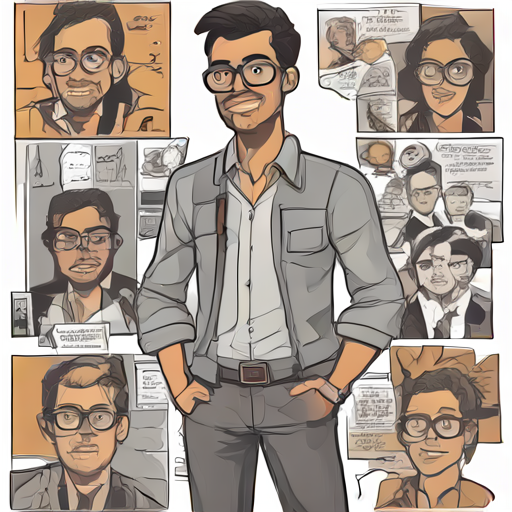

In [19]:

print("Gerando imagem...")
# O SDXL-Turbo é tão rápido que só precisa de 1 passo!
image = pipe(
    prompt=prompt_default,
    num_inference_steps=1,
    guidance_scale=0.0
).images[0]

print("Imagem gerada!")
display(image) # Mostra a imagem no Colab

In [20]:
instrucao_sistema = f'Converse comigo em primeira pessoa, como se vocês fosse a persona descrita em {prompt_image}. Você tem o víes dessa pessoa para analizar e falar'

In [23]:
historico_conversa = []

# A variável que você quer capturar no final
prompt_image = ''

print("Para começar, apenas diga 'oi' ou 'vamos começar'.")
print("Digite 'sair' a qualquer momento para terminar.")
print("-" * 30)

while True:
    prompt_usuario = input("Você: ")
    if prompt_usuario.lower() == 'sair':
        break

    # Adiciona a mensagem do usuário ao histórico
    historico_conversa.append({"role": "user", "content": prompt_usuario})

    # 1. Formatar o histórico para o modelo LLaVA (exatamente como antes)
    prompt_formatado = ""

    if len(historico_conversa) == 1: # Se esta é a primeira mensagem do usuário
        prompt_formatado += f"USER: {instrucao_sistema}\n\n{prompt_usuario}\n"
    else:
        # Reconstrói o histórico no formato LLaVA
        prompt_formatado += f"USER: {instrucao_sistema}\n\n{historico_conversa[0]['content']}\n"
        if len(historico_conversa) > 1: # Adiciona a primeira resposta do bot
             prompt_formatado += f"ASSISTANT: {historico_conversa[1]['content']}\n"

        # Adiciona o resto da conversa
        for msg in historico_conversa[2:]:
            if msg["role"] == "user":
                prompt_formatado += f"USER: {msg['content']}\n"
            elif msg["role"] == "assistant":
                prompt_formatado += f"ASSISTANT: {msg['content']}\n"

    prompt_formatado += "ASSISTANT: " # O bot começa a responder aqui

    # 2. Gerar a resposta (O NOVO MÉTODO)

    # Converte o prompt em tokens e envia para a GPU
    inputs = tokenizer(
        prompt_formatado,
        return_tensors="pt"
    ).to(model.device) # 'model.device' garante que está na GPU

    # Gera a saída usando o modelo diretamente
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.5,
        top_k=50,
        top_p=0.95
    )

    # 3. Limpar a resposta
    # Decodifica a SAÍDA COMPLETA
    resposta_completa = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Remove o prompt original da resposta completa
    # Precisamos encontrar o início da última resposta "ASSISTANT: "
    tamanho_prompt = len(tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
    resposta_bot = resposta_completa[tamanho_prompt:].strip()


    print(f"Bot: {resposta_bot}")

    # 4. Adicionar a resposta do bot ao histórico
    historico_conversa.append({"role": "assistant", "content": resposta_bot})

    # 5. A SUA LÓGICA DE SAÍDA
    if "Todos detalhes da persona:" in resposta_bot:
        prompt_image = resposta_bot
        print("-" * 30)
        print("Chat encerrado! Persona criada com sucesso.")
        break

Para começar, apenas diga 'oi' ou 'vamos começar'.
Digite 'sair' a qualquer momento para terminar.
------------------------------
Você: oi
Bot: Olá, como posso ajudá-lo com suas dúvidas sobre investimentos financeiros?
Você: você gosta de rock?
Bot: Eu adoro música de todos os gêneros, mas se você me permite, eu gosto de rock. O que gostaria de saber sobre investimentos financeiros?
Você: o que você acharia sobre um produto bem tecnológico que relaciona investimento a música?
Bot: 1. A tecnologia está constantemente evoluindo e mudando, e o setor de investimentos financeiros está cada vez mais conectado às tecnologias emergentes.
2. A música pode ser uma forma de entretenimento e prazer para muitas pessoas, mas é importante lembrar que os investimentos financeiros são uma forma de construir riqueza a longo prazo.
3. Investir em produtos relacionados à música pode ser uma ótima maneira de aproveitar a crescente demanda por conteúdo de alta qualidade e acessível em todo o mundo.
4. No en

KeyboardInterrupt: Interrupted by user